<img src='./images/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='20%'></img>

**Author:** Luigi Selmi <br>
**Copyright:** 2022 Luigi Selmi <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>2m air temperature from the ERA5-Land dataset</h3></div>

# INTRODUCTION
The Copernicus Climate Change Service ([C3S](https://climate.copernicus.eu/)) provides information about climate change through  historical data sets (reanalysis) and projections of essential climate variables such as winds, precipitation, temperature, pressure, greenhouse gases. C3S is operated by the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int/)) on behalf of the European Commission. The [2m air surface temperature](https://gcos.wmo.int/en/essential-climate-variables/surface-temperature/) is one of the 54 essential climate variables of the World Meteorological Organization (WMO). It has a direct impact on the natural systems and human lives and is a key indicator of climate change. 

|![Global air temperature](images/global_air_temperature.png)|
|:--:|
|*Global air temperature - (Credit: UEA Climatic Research Unit)*|


### Data used 

| Product Description | Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-------------:|:-----------------:|:-----------------:|
| CAMS ERA5-Land hourly data from 1950 to present | <a href="https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-solar-radiation-timeseries?tab=overview" target="_blank">link</a> | EO:ECMWF:DAT:REANALYSIS_ERA5_LAND | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AREANALYSIS_ERA5_LAND" target="_blank">link</a> |

### Learning outcomes

In this notebook you will learn;

* The reanalysis process used to produce the ERA5 dataset
* The data assimilation method used to combine the output of numerical model with new observations
* How to download and plot the 2m air temperature for a region on a geographical map
* As an exercise, we compute the mean daily temperatures in Rome in April 2022 and then we plot the result.  

### Outline

We use the [C3S ERA5-Land hourly data from 1950 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview) data set to retrieve the air temperature over the Italian region in May 2022. The 2m temperature is the temperature of the air at 2m above the land. Since we want to limit the size of the data we choose a time step of 3 hours. The format of the data is [NetCDF4](https://www.unidata.ucar.edu/software/netcdf/docs/netcdf_introduction.html). According to our selection the data will contain a cube of 8 time slices per day of temperature values, for each grid point in the selected area. The selected area is between 47.12 degrees latitude North, 36.4 latitude South and 6.57 degrees longitude West and 18.52 longitude East. The area contains 43x48 = 2064 points so each table, or slice, contains 2064 temperature values (in Kelvin).

<div class="alert alert-info" role="alert">

### <a id='TOC_TOP'></a>Contents

</div>
    
 1. [The ERA5 reanalysis dataset](#The-ERA5-reanalysis-dataset)
 2. [Data assimilation](#Data-assimilation)
 3. [The Harmonised Data Access API](#The-Harmonised-Data-Access-API)
 4. [Multidimensional arrays](#Multidimensional-arrays)
 5. [Plotting the temperature data](#Plotting-the-temperature-data)
 6. [Computing the mean daily air temperature](#Computing-the-mean-daily-air-temperature)
 7. [Data points interpolation](#Data-points-interpolation)
 8. [References](#References)

<hr>

<div class="alert alert-info" role="alert">

## <a id='The-ERA5-reanalysis-dataset'></a>1. The ERA5-Land reanalysis dataset
[Back to top](#TOC_TOP)

</div>

ERA5-Land reanalysis is a dataset that combines a vast amount of in-situ and satellite observations of the climate variables from the near real time back to 1950. The aim of the project is to assimilate historical observations back to 1950. The dataset is provided as a level 3 product so that the observations are already interpolated at the grid points. ERA5 contains estimations of many climate variables on a grid whose horizontal resolution, the distance between any two points on the grid, is 0.1°x0.1° or 9 km. The ERA5 estimations are computed by integrating the values obtained using the ECMWF climate model with the historical observations from in-situ and satellite data. The air temperature is calculated by interpolating the value of the model with the Land Surface Temperature, or skin temperature, such as that provided by the SLSTR radiometer on board Sentinel-3, taking into account the atmospheric conditions.  

<div class="alert alert-info" role="alert">

## <a id='Data-assimilation'></a>2. Data assimilation
[Back to contents](#Contents)
</div>

The technique used to integrate the model data with the observations is called assimilation. An estimation of the state of the climate variables is computed for every hour by ECMWF earth system model. The model estimations are compared with the observations at any grid point. Since both observations and model data have errors a cost function is used to compute the distance between the two values, weighted by their errors. The result, obtained by minimizing the cost function, represents a better estimation of the climate variables at any time slice and grid point. The set of estimations, corrected using the observations, represents an analysis that is used as input for the next iteration of the model. The result will be again compared with the observations available at that time slice to produce the corresponding analysis. More information about the technique can be found in the [references](#References)          

<div class="alert alert-info" role="alert">

## <a id='The-Harmonised-Data-Access-API'></a>3. The Harmonised Data Access API
[Back to contents](#Contents)
</div>

The C3S datasets are available under an open data policy through the Harmonized Data Access (HDA) API. For the ERA5-Land dataset a user can select

- the variables, that is the physical parameters we are interested in 
- the area of interest, or bounding box, delimited by north and south latitudes and west and east longitudes 
- the years, months, days and hours for which the user wants the reanalysis data
- the format of the data (GRIB, NetCDF)

In this notebook we use the web service through its API. In order to use the API you need your user name and password that have created in order to register into the [Wekeo](https://www.wekeo.eu/) website. The steps to use the HDA API are

1. install the HDA api Python package
2. write your user name and token into the HDA client
3. send the request and wait for the response with the data

We set some parameters before submitting our request, in particular the area of interest and the variable (2m temperature).
We import all the Python packages that will be used to retrieve the data. We will import additional packages later on for plotting the temperatures.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from hda import Client
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)

python version: 3.9.13
pandas version: 1.4.3
xarray version: 2022.3.0


In [2]:
bb_north = 47.50379785942417
bb_south = 34.82621887953009
bb_west = 5.899000073477433
bb_east = 20.721255946087158
variable = "2m_temperature"

In [3]:
data = {
  "datasetId": "EO:ECMWF:DAT:REANALYSIS_ERA5_LAND",
  "boundingBoxValues": [
    {
      "name": "area",
      "bbox": [
        bb_west,
        bb_north,
        bb_east,
        bb_south
      ]
    }
  ],
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        variable
      ]
    },
    {
      "name": "year",
      "value": [
        "2022"
      ]
    },
    {
      "name": "month",
      "value": [
        "04",
        "05"
      ]
    },
    {
      "name": "day",
      "value": [
        "01", "02", "03", "04", "05", 
        "06", "08", "07", "09", "10", 
        "11", "12", "13", "14", "15",
        "16", "17", "18", "19", "20", 
        "21", "22", "23", "24", "25", 
        "26", "27", "28", "29", "30", 
        "31"
      ]
    },
    {
      "name": "time",
      "value": [
        "00:00", "03:00", "06:00",
        "09:00", "12:00", "15:00",
        "18:00", "21:00"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "format",
      "value": "netcdf"
    }
  ]
}

In [4]:
c = Client(url='https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker', user='xxxxxxxx', password='xxxxxxxxxx')
matches = c.search(data)
matches.download()

2023-01-26 21:46:11,794 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/rgqnSxfI2gZaQLdnMYmiMaG0-wE to adaptor.mars.internal-1674765954.2514956-22309-9-c4a08285-3776-423f-8817-10660b5d439d.nc (17.6M)
2023-01-26 21:47:51,285 INFO Download rate 181.3K/s


In [5]:
for match in matches.results:
    fdst = match['filename']
    print(f"Found: {fdst}")

Found: adaptor.mars.internal-1674765954.2514956-22309-9-c4a08285-3776-423f-8817-10660b5d439d.nc


We move the data into a dedicated folder

In [6]:
import os
os.rename(fdst, 'data/era5/2m_temperature.nc')

We read the data and visualize some information about the content. The date time is provided as time steps from the beginning date but since we will select the data between two dates we convert the steps into dates using the decode_cf() function.

In [7]:
era5_ds = xr.open_dataset('data/era5/2m_temperature.nc')
xr.decode_cf(era5_ds)
era5_ds

<xarray.Dataset>
Dimensions:    (longitude: 149, latitude: 127, time: 488)
Coordinates:
  * longitude  (longitude) float32 5.899 5.999 6.099 6.199 ... 20.5 20.6 20.7
  * latitude   (latitude) float32 47.43 47.33 47.23 47.13 ... 35.03 34.93 34.83
  * time       (time) datetime64[ns] 2022-04-01 ... 2022-05-31T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-26 20:45:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

As we can see from the dimensions, the data contains 149x127 = 18923 grid points for each time slice between April 1st and April 30th 2022.

In [8]:
lats = era5_ds['latitude']
print("Latitude South: {0:.2f}, Latitude North: {1:.2f}".format(lats.data.min(), lats.data.max()))

Latitude South: 34.83, Latitude North: 47.43


In [9]:
lons = era5_ds['longitude']
print("Longitude West: {0:.2f}, Longitude East: {1:.2f}".format(lons.data.min(), lons.data.max()))

Longitude West: 5.90, Longitude East: 20.70


Now we extract the temperature data from the data set and then we close the file since we won't need it anymore. 

In [10]:
temperature2m = era5_ds['t2m']
era5_ds.close()

<div class="alert alert-info" role="alert">

## <a id='Multidimensional-arrays'></a>4. Multidimensional arrays
[Back to contents](#Contents)
</div>

The temperatures are stored in a three dimensional array as shown in the picture, so that each temperature value is addressed by three coordinates or indexes. The first index represents the time slices, the 2nd and 3rd indexes represent the latitude and the longitude respectively. Instead of using integer indexes, as in a normal array, we can use a time index, and latitude and longitude as space indexes. The values for time, latitude and longitude must be the exact values that are in the data array. The use of index values that are different from those available in the data array will result in a key error. We need to know only the first value of each index and the distance between two consecutive values. For the time index the distance is 3 hours and for latitute and longitude is 0.10 degrees.

![GitHub Logo](images/xarray-temperature-diagram.png)

Here we choose two different time slices at the same grid point to compute the mean temporal temperature

In [11]:
temp1 = temperature2m.sel(time='2022-04-15T12:00:00', latitude = 46.927, longitude = 6.599).values.item()
temp2 = temperature2m.sel(time='2022-04-15T15:00:00', latitude = 46.927, longitude = 6.599).values.item()
temporal_mean = (temp2 + temp1) / 2
print("Mean Temperature between two time slots °C: {0:.2f}".format(temporal_mean - 273.15))

Mean Temperature between two time slots °C: 15.08


Here we compute the mean temperature in two different adjacent grid points at the same time

In [12]:
tempA = temperature2m.sel(time='2022-04-30T15:00:00', latitude = 46.927, longitude = 6.599).values.item()
tempB = temperature2m.sel(time='2022-04-30T15:00:00', latitude = 46.927, longitude = 6.699).values.item()
spatial_mean = (tempA + tempB) / 2
print("Mean Temperature between two grid points °C: {0:.2f}".format(spatial_mean - 273.15))

Mean Temperature between two grid points °C: 10.45


<div class="alert alert-info" role="alert">

## <a id='Plotting-the-temperature-data'></a>5. Plotting the temperature data
[Back to contents](#Contents)
</div>

We want to plot on a map one time slice of the temperature values, so we import the Python libraries.

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
print("matplotlib version: %s"%matplotlib.__version__)
print("cartopy version: %s"%cartopy.__version__)

matplotlib version: 3.5.2
cartopy version: 0.20.3


We plot the data on a map using the [plate carre projection](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#platecarree), a particular case of the [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection). We plot the costline and also rivers and lakes just to show that they are available. We plot only the time slice of April 15th 2022 at 15:00.

Text(0.5, 1.0, 'ERA5-Land 2 meter air temperature - 2022-04-15T15:00:00')

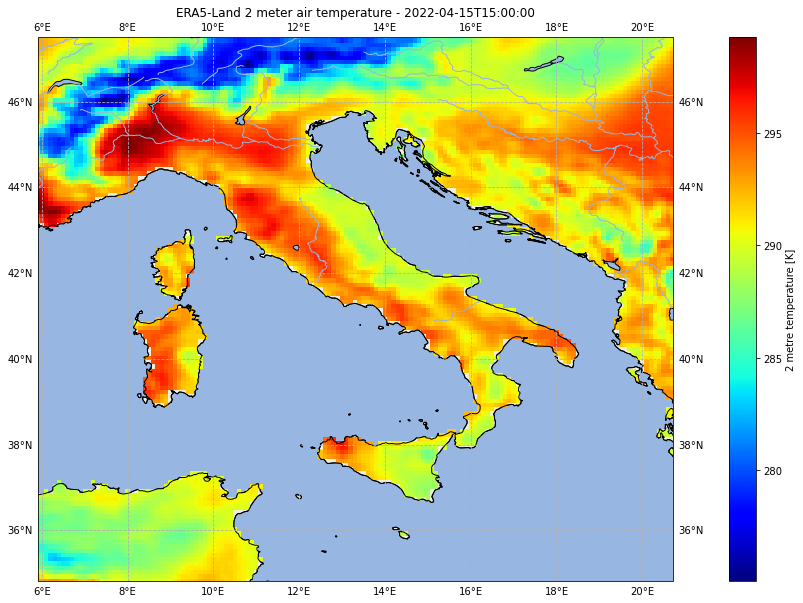

In [14]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linestyle='--')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.coastlines()
ax.set_extent([bb_west, bb_east, bb_south, bb_north], ccrs.PlateCarree())
temperature2m.sel(time='2022-04-15T15:00:00').plot(ax=ax, add_colorbar=True, cmap='jet')
plt.title('ERA5-Land 2 meter air temperature - 2022-04-15T15:00:00')

The color of each cell, centered on one of the grid points, represents the temperature value.

We plot the data using the orthographic projection on the entire globe as well, even if our data cover only the Italian region. In order to plot the data into a different projection we need to transform the coordinates of the grid points. The transformation is performed by the cartopy library.

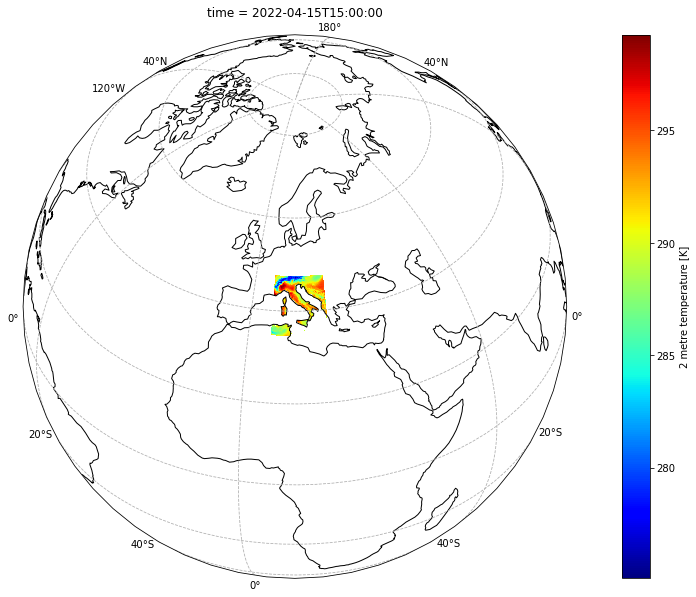

In [15]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=12, central_latitude=41))
ax.gridlines(draw_labels=True, linestyle='--')
ax.coastlines()
ax.set_global()
temperature2m.sel(time='2022-04-15T15:00:00').plot(ax=ax,  
                                   add_colorbar=True, 
                                   cmap='jet', 
                                   transform=ccrs.PlateCarree())

<div class="alert alert-info" role="alert">

## <a id='Computing-the-mean-daily-air-temperature'></a>6. Computing the mean daily air temperature
[Back to contents](#Contents)
</div>

We want to compute the time series of the 2 meter air temperature in Rome for the month of April, the last month for which the data is available at the time of writing the notebook. We select the time slices from April 1st to May 1st, 8 time slices per day, and for each slice we select the grid points that lay within a bounding box between latitude Nord = 42.12 degrees and latitude South = 41.70 degrees, and between longitude West = 12.23 degrees and longitude East = 12.70 degrees. Then we compute the daily mean temperature and finally we plot the time series of the 2m daily mean air temperature. 

In [16]:
rome_bb_north = 42.12
rome_bb_south = 41.70
rome_bb_west = 12.23
rome_bb_east = 12.70
rome_temp = temperature2m.sel(
                            time = slice('2022-04-01T00:00:00', '2022-05-01T00:00:00'),
                            latitude = slice(rome_bb_north, rome_bb_south), 
                            longitude = slice(rome_bb_west, rome_bb_east))

We substitute the NaN values in some cells with interpolated values of other cells 

In [17]:
rome_temp = rome_temp.interpolate_na(dim='longitude', method='linear', fill_value='extrapolate')
rome_temp.shape

(241, 4, 5)

Text(0.5, 1.0, 'ERA5 2 meter air temperature - 2022-04-15T15:00:00')

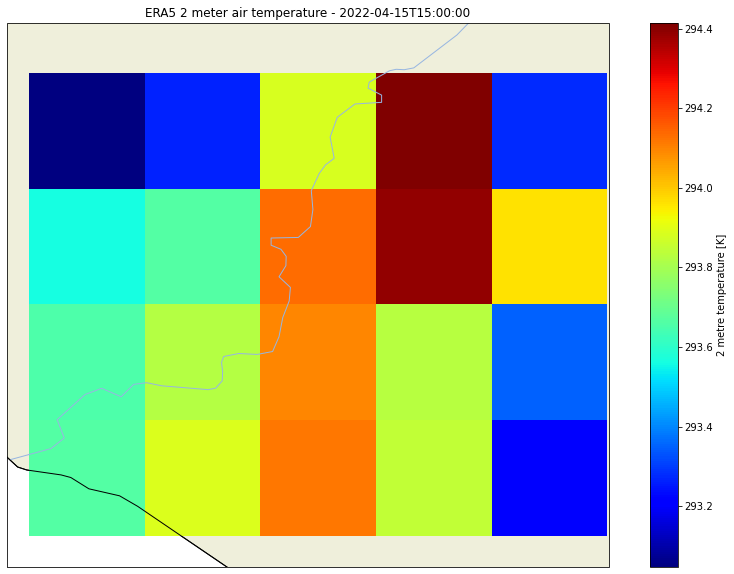

In [18]:
plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.coastlines()
ax.set_extent([rome_bb_west, rome_bb_east + 0.05, rome_bb_south - 0.05, rome_bb_north], ccrs.PlateCarree())
rome_temp.sel(time='2022-04-21T12:00:00').plot(ax=ax, add_colorbar=True, cmap='jet')
plt.title('ERA5 2 meter air temperature - 2022-04-15T15:00:00')

As we can seen, our selection contains 30x8 + 1 = 241 time slices and only 4x5 = 20 grid points for each time slice. We resample (downsample) the temperatures from hours to days so that we will have 31 time slices.

In [19]:
rome_temp_daily_max = rome_temp.resample(time='1D').max()
rome_temp_daily_min = rome_temp.resample(time='1D').min()

We compute the mean daily temperature of the grid points for each time slice as the sum of the minimum and the maximum temperature value divided by two. We will also compute the spatial mean value of the temperature for each time slice.

In [20]:
rome_temp_daily_mean = (rome_temp_daily_max + rome_temp_daily_min) / 2
rome_temp_daily_spatial_mean = rome_temp_daily_mean.mean(dim=['longitude', 'latitude'])
rome_temp_daily_spatial_mean

<xarray.DataArray 't2m' (time: 31)>
array([284.3777 , 280.6999 , 281.6213 , 282.46945, 283.34268, 283.15292,
       284.35675, 286.5764 , 286.18866, 284.23242, 282.76172, 283.9206 ,
       286.45758, 287.5451 , 288.71747, 289.26535, 286.8227 , 285.79425,
       284.76813, 287.70596, 289.7172 , 286.5176 , 287.3658 , 288.28076,
       287.5765 , 287.6863 , 287.8867 , 289.72015, 289.11966, 289.26212,
       286.81882], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2022-05-01

Finally we plot the time series of the 2m air temperatures for the city of Rome in April 2022.

Text(0.5, 0.98, 'Mean daily 2 meter air temperature - Rome, April 2022 (°C)')

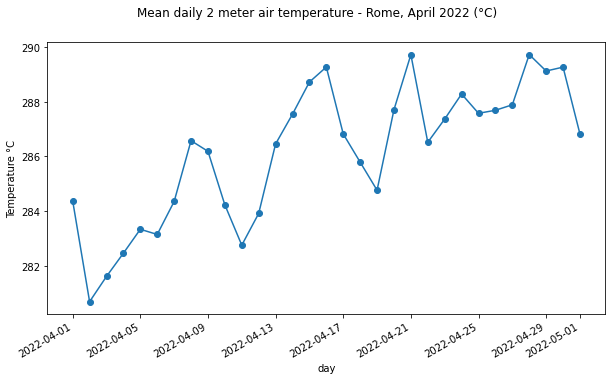

In [21]:
fig = plt.figure(figsize=(10, 5))
ax.set_ylabel("Temperature °C");
rome_temp_daily_spatial_mean.plot(marker='o')
plt.xlabel("day")
plt.ylabel("Temperature °C")
plt.suptitle("Mean daily 2 meter air temperature - Rome, April 2022 (°C)")

<div class="alert alert-info" role="alert">

## <a id='Data-points-interpolation'></a>7. Data points interpolation
[Back to contents](#Contents)
</div>

We may want to interpolate the temperature data and find a function, as simple as possible, that approximates the data points. 
One common way is to define a function of polynomials, with the lowest degree, that fits the data points. From the previous plot we can see that maybe a linear function wouldn't probably be the best solution and neither a 2nd degree polynomial because the value of the data points is not decreasing in the interval of choice. So we decide for a 3rd degree polynomial of type

$$y = a + b*x + c*x^2 + d * x^3$$

We use the SciPy curve_fit() function to compute the coefficients of the 3rd degree polynomial that fits the data points at best.

In [22]:
from scipy.optimize import curve_fit
# Creating a polynomnial function to model the data
def polynomialfunc(x, a, b, c, d):
    return a + b * x + c * x * x + d * x * x * x

The curve_fit() function requires real numbers for the independent variable not dates so we create a vector, of the same size, of real values to use in place of the date times. The function returns the coefficients and the covariances, we use only the coefficients.

In [23]:
length = len(rome_temp_daily_spatial_mean)
x = np.linspace(0, length, length)
temperature = xr.DataArray(rome_temp_daily_spatial_mean, dims="x", coords={"x": x})
popt, pcov = curve_fit(polynomialfunc, x, temperature)
print("Polynomial coefficients \na = {0:5.2f} \nb = {1:5.2f} \nc = {2:5.4f} \nd = {3:5.7f}".format(popt[0], popt[1], popt[2], popt[3]))  

Polynomial coefficients 
a = 282.00 
b =  0.36 
c = -0.0015 
d = -0.0001134


With the coefficients of the polynomial we can plot the interpolation on top of the data points to see how it fits

Text(0.5, 0.98, 'Interpolated Mean 2 meter air temperature - Rome, April 2022 (°C)')

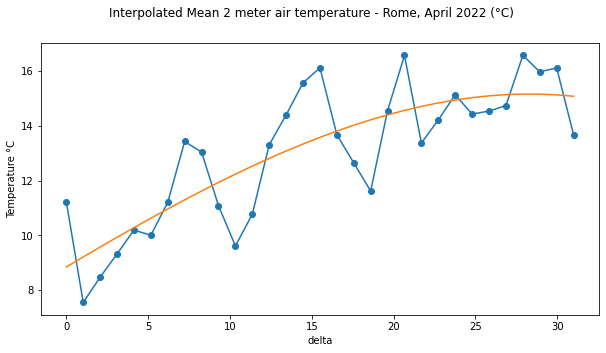

In [24]:
temperature_fit = polynomialfunc(x, popt[0], popt[1], popt[2], popt[3])
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.set_xlabel("delta")
ax.set_ylabel("Temperature °C");
plt.plot(x, temperature - 273.15, marker='o')
plt.plot(x, temperature_fit - 273.15)
plt.suptitle("Interpolated Mean 2 meter air temperature - Rome, April 2022 (°C)")

It seems that a 3rd degree polynomial fits quite well our data points. We might need a better approximation and for that we will need to use a higher degree polynomial, anyway it might not provide such a great improvement and it will certainly be more computationally expensive.

<div class="alert alert-info" role="alert">

## <a id='References'></a>8. References
[Back to contents](#Contents)
</div>

- [Hersbach et al. - The ERA5 global reanalysis](https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/qj.3803)
- [Hansen et al. - Global Trends of Measured Surface Air Temperature](https://pubs.giss.nasa.gov/abs/ha00700d.html)
- [Talagrand - Assimilation of Information, an Introduction](https://indico.fysik.su.se/event/2654/attachments/1559/1707/Talagrand.1987.pdf)
- [Law et al. - Data Assimilation: A Mathematical Introduction](https://arxiv.org/abs/1506.07825)
- [Carrassi et al. - Data Assimilation in the Geosciences](https://arxiv.org/abs/1709.02798)
- [Wikle et al. - A Bayesian tutorial for data assimilation](https://doi.org/10.1016/j.physd.2006.09.017) 
- [Geohackweek - Multidimensional Arrays](https://geohackweek.github.io/nDarrays/)
- [GEOGO133 - Terrestrial Carbon: Modelling and Monitoring 9) Data Assimilation](https://geog0113.readthedocs.io/en/latest/da.html)
- [ECMWF - Integrated Forecasting System Documentation](https://www.ecmwf.int/en/publications/ifs-documentation)

<div class="alert alert-block alert-warning">

### Challenge:

You may want to choose a different area to see what is trend of the surface air temperature there, or you may want to go farer back in time or compare a time period with one 10 years before and see whether there has been an increase in the mean daily temperature values. You can do all these opertions by following the code snippet in this notebook and changing the relevant parameters. 
<div>